In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from itertools import permutations
import healpy as hp

from scipy import interpolate
from scipy.interpolate import SmoothSphereBivariateSpline
import scipy.fft as fft

from image_code import image_calculation_functions as ic

from astropy.coordinates.tests.utils import randomly_sample_sphere
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time


%load_ext autoreload
%autoreload 2

In [35]:
theta_p = 181
phi_p = 361
phi = np.linspace(-180,180,phi_p)*np.pi/180
theta = np.linspace(0,90,int(theta_p/2)+1)*np.pi/180
P,T = np.meshgrid(phi,theta)



In [3]:
ra_list,dec_list,flux_0p6,flux_2,flux_10 = np.loadtxt('/data4/nmahesh/edges/Lunar/catalog/GLEAM_Scut-1Jyto28kJy-3freqs.txt',skiprows=1,usecols=(1,2,3,4,5),unpack=True)

In [4]:
far_array=np.load('/data4/nmahesh/edges/Lunar/array_layout/farside_array_nooffset.npy')
far_array_off=np.load('/data4/nmahesh/edges/Lunar/array_layout/farside_array_offset.npy')

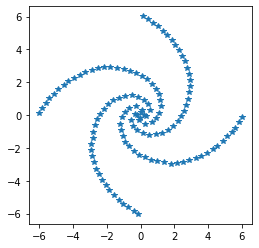

In [6]:
plt.figure(figsize=(4,4))
plt.plot(far_array[:,0],far_array[:,1],'*')

In [36]:

beam_squarel,ethetal, ephil=ic.read_feko('/data4/nmahesh/edges/Lunar/beam_files/dipole_0p1-1MHz_regolith-0',31,theta_p,phi_p)
beam_squarel90,ethetal90,ephil90=ic.read_feko('/data4/nmahesh/edges/Lunar/beam_files/dipole_0p1-1MHz_regolith-90',31,theta_p,phi_p)

beam_squareh,ethetah, ephih = ic.read_feko('/data4/nmahesh/edges/Lunar/beam_files/dipole_0p4-40MHz_regolith',10,theta_p,phi_p)
beam_squareh90,ethetah90,ephih90 = ic.read_feko('/data4/nmahesh/edges/Lunar/beam_files/dipole_0p4-40MHz_regolith-90',10,theta_p,phi_p)


In [37]:

sample = 1

if sample==0:
    wav = 500 #in m; f = 0.6 MHz
    index = 17
    beam_square,etheta, ephi = beam_squarel,ethetal, ephil
    beam_square90,etheta90,ephi90 = beam_squarel90,ethetal90,ephil90
    flux_list = flux_0p6
    factor =150
elif sample==1:
    wav = 150 # in m; f = 2MHz
    index = 3
    beam_square,etheta, ephi = beam_squareh,ethetah, ephih
    beam_square90,etheta90,ephi90=beam_squareh90,ethetah90,ephih90
    flux_list = flux_2
    factor =500
elif sample==2:
    
    wav = 30 # in m; f = 10MHz
    index = 4
    beam_square,etheta, ephi = beam_squareh,ethetah, ephih
    beam_square90,etheta90,ephi90=beam_squareh90,ethetah90,ephih90
    flux_list = flux_10
    factor =2500
    
f = 300/wav
####Normalizing by 2 MHz
l_grid = np.linspace(-1,1,int(factor))
m_grid = l_grid
L,M = np.meshgrid(l_grid,m_grid)

q = L**2+M**2
el = np.sqrt(1 - q)
el[q>=1] = 0
p =-np.arctan2(M,L) 
t = np.pi/2 - np.arcsin(el)#-np.arcsin(L,(np.sin(p)))+np.pi/2

etheta = np.roll(etheta,180,axis=2)/np.max(ethetah[3,:,:])
etheta90 = np.roll(etheta90,180,axis=2)/np.max(ethetah90[3,:,:])
ephi = np.roll(ephi,180,axis=2)/np.max(ephih[3,:,:])
ephi90 = np.roll(ephi90,180,axis=2)/np.max(ephih90[3,:,:])


ra_list_c = ra_list
dec_list_c = dec_list
flux_list_c = flux_list

<ipython-input-37-e1b10353d5d3>:33: RuntimeWarning: invalid value encountered in sqrt
  el = np.sqrt(1 - q)


In [38]:
beam_etheta = ic.beam_interpolate(etheta[index],theta,phi,t,p)
beam_etheta90 = ic.beam_interpolate(etheta90[index],theta,phi,t,p)

beam_ephi = ic.beam_interpolate(ephi[index],theta,phi,t,p)
beam_ephi90 = ic.beam_interpolate(ephi90[index],theta,phi,t,p)



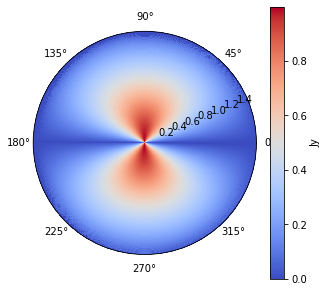

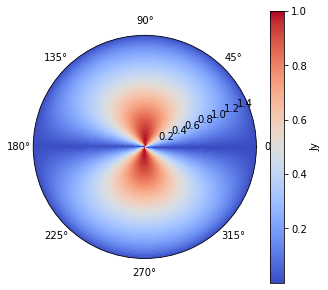

In [54]:
fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
p1 =ax.pcolormesh(p,t,np.abs(beam_etheta90),cmap='coolwarm')#vmin=-10, vmax =1000)
plt.colorbar(p1, ax=ax,label='Jy')


fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
p1 =ax.pcolormesh(P,T,np.abs(etheta90[index,:91]),cmap='coolwarm')#vmin=-10, vmax =1000)
plt.colorbar(p1, ax=ax,label='Jy')

In [55]:
off = np.linspace(-12,12,24)*u.hour
cyg_a_altaz = np.zeros((len(off),2))
cyg_A = ic.processed_source()



for i in range(len(off)):
    cyg_A.init_skycoord('19 59 28.35645829 +40 44 02.0966496', Time.now()+off[i])
    cyg_a_altaz[i] = cyg_A.obj_a_altaz
    
time = Time.now()+off[5]
t2 = Time(time, scale='utc',location=('180d', '0d'))
lst = t2.sidereal_time('apparent').value
print(t2,lst)

2021-12-30 16:46:20.052916 11.395131218694834


In [56]:
sky_obj = ic.processed_source()
sky_obj.init_skycoords(ra_list_c,dec_list_c,flux_list_c,time)

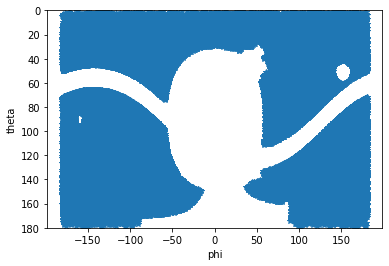

In [57]:
sky_obj.plot_skymap()

In [58]:
sky_obj.tp_to_lm(30,l_grid,m_grid)

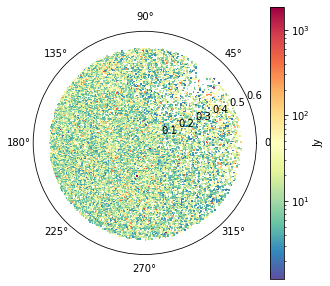

In [59]:
fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
p1 =ax.pcolormesh(p,t,sky_obj.sky_map,cmap='Spectral_r',norm= LogNorm())#vmin=-10, vmax =1000)
ax.set_ylim([0,35*np.pi/180])
plt.colorbar(p1, ax=ax,label='Jy')

In [60]:
sky_obj.calculate_delphi(50,wav,L,M)

In [61]:
off_err =np.random.normal(50, 0.01, np.shape(far_array)[0])


In [62]:
J = np.array([[beam_etheta,beam_ephi] ,[beam_etheta90,beam_ephi90]])

In [63]:
sky_obj.make_sky_coherence()
sky_obj.make_offset_jacob(J)

In [64]:
sky_obj.invert_offset_jacob()
sky_obj.offset_ft()

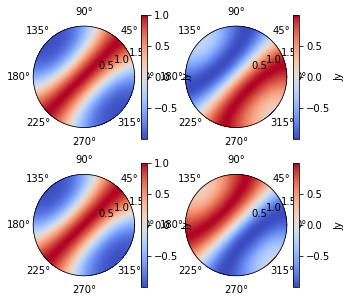

In [65]:
fig,ax = plt.subplots(2,2, subplot_kw=dict(polar=True),figsize=(5,5))
p1 =ax[0,0].pcolormesh(p,t,np.real(sky_obj.J_b[1,1]),cmap='coolwarm')
plt.colorbar(p1, ax=ax[0,0],label='Jy')

p1 =ax[0,1].pcolormesh(p,t,np.imag(sky_obj.J_b[1,1]),cmap='coolwarm')
plt.colorbar(p1, ax=ax[0,1],label='Jy')


p1 =ax[1,0].pcolormesh(p,t,np.real(sky_obj.J_in[1,1]),cmap='coolwarm')
plt.colorbar(p1, ax=ax[1,0],label='Jy')

p1 =ax[1,1].pcolormesh(p,t,np.imag(sky_obj.J_in[1,1]),cmap='coolwarm')
plt.colorbar(p1, ax=ax[1,1],label='Jy')

In [66]:
sky_obj.make_pseudo_vis(J)

In [67]:
vis_temp_back = np.zeros_like(sky_obj.J_off,dtype=np.complex128)
vis_back = np.zeros_like(sky_obj.J_off,dtype=np.complex128)
for a in range(2):
    for b in range(2):

        #vis_temp[a,b]= np.sum(sky_obj.J_in[a,:] * self.sky_coherence[:,b],axis=0)
        vis_temp_back[a,b]= np.sum(sky_obj.J_in[a,:] * sky_obj.vis_off[:,b],axis=0)
       
for a in range(2):
    for b in range(2):

        #self.vis[a,b]= np.sum(vis_temp[a,:] * np.conj(J[b,:]),axis=0)
        vis_back[a,b]= np.sum(vis_temp_back[a,:] * np.conj(sky_obj.J_in[b,:]),axis=0)
       

(0, 0.6108652381980153)

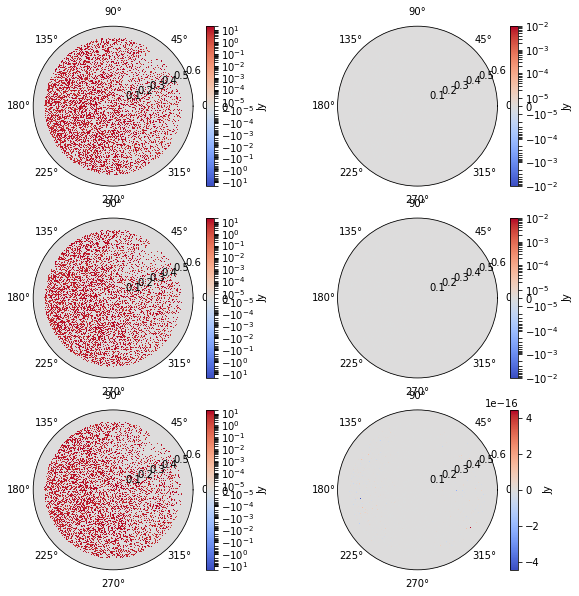

In [72]:
fig,ax = plt.subplots(3,2, subplot_kw=dict(polar=True),figsize=(10,10))
p1 =ax[0,0].pcolormesh(p,t,np.real(sky_obj.vis[0,0]),cmap='coolwarm',norm=SymLogNorm(linthresh=2e-5,vmin=-20, vmax =20))
plt.colorbar(p1, ax=ax[0,0],label='Jy')
ax[0,0].set_ylim([0,35*np.pi/180])

p1 =ax[0,1].pcolormesh(p,t,np.imag(sky_obj.vis[0,0]),cmap='coolwarm',norm=SymLogNorm(linthresh=2e-5,vmin=-1e-2, vmax =1e-2))
plt.colorbar(p1, ax=ax[0,1],label='Jy')
ax[0,1].set_ylim([0,35*np.pi/180])

p1 =ax[1,0].pcolormesh(p,t,np.real(sky_obj.vis_off[0,0]),cmap='coolwarm',norm=SymLogNorm(linthresh=2e-5, vmin=-20, vmax =20))
plt.colorbar(p1, ax=ax[1,0],label='Jy')
ax[1,0].set_ylim([0,35*np.pi/180])

p1 =ax[1,1].pcolormesh(p,t,np.imag(sky_obj.vis_off[0,0]),cmap='coolwarm',norm=SymLogNorm(linthresh=2e-5,vmin=-1e-2, vmax =1e-2))
plt.colorbar(p1, ax=ax[1,1],label='Jy')
ax[1,1].set_ylim([0,35*np.pi/180])

p1 =ax[2,0].pcolormesh(p,t,np.real(vis_back[0,0]),cmap='coolwarm',norm=SymLogNorm(linthresh=2e-5,vmin=-20, vmax =20))
plt.colorbar(p1, ax=ax[2,0],label='Jy')
ax[2,0].set_ylim([0,35*np.pi/180])

p1 =ax[2,1].pcolormesh(p,t,np.imag(vis_back[0,0]),cmap='coolwarm')#,norm=SymLogNorm(linthresh=2e-5,vmin=-1e-2, vmax =1e-2))
plt.colorbar(p1, ax=ax[2,1],label='Jy')
ax[2,1].set_ylim([0,35*np.pi/180])

In [84]:
sky_obj.uvcal(wav,far_array)
sky_obj.make_dirty_image(off_c=0)


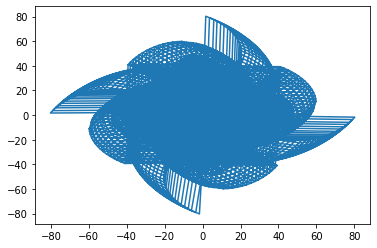

In [85]:
plt.plot(sky_obj.u,sky_obj.v)

In [75]:
x = np.linspace(-60,60,128)
y = x.T

In [76]:
b = np.repeat(x[:, np.newaxis], 128, axis=1)
c = np.repeat(y[np.newaxis, :], 128, axis=0)

In [77]:
 sky_obj.u = b.flatten()
 sky_obj.v = c.flatten()


In [86]:
sky_obj.make_dirty_image(off_c=0)
corrected=ic.offset_correction(sky_obj.J_in,sky_obj.image_off)

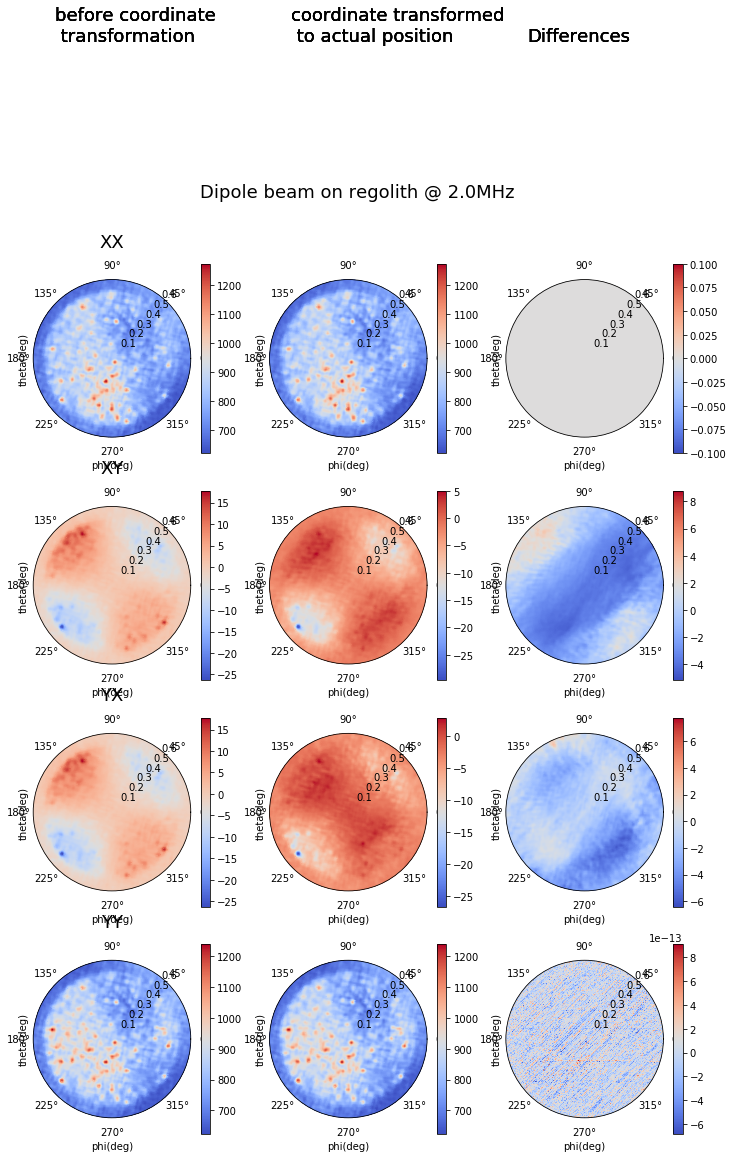

In [87]:

final = np.zeros((4,np.shape(sky_obj.beam_ft)[2],np.shape(sky_obj.beam_ft)[3]),dtype = np.complex128)
final_off = np.zeros((4,np.shape(sky_obj.beam_ft)[2],np.shape(sky_obj.beam_ft)[3]),dtype = np.complex128)
final_offc = np.zeros((4,np.shape(sky_obj.beam_ft)[2],np.shape(sky_obj.beam_ft)[3]),dtype = np.complex128)

fig,ax = plt.subplots(4,3, subplot_kw=dict(polar=True),figsize=(12,16))
text = ['XX','XY','YX','YY']

c=0
for i in range(2):
    for j in range(2):
        final[c] = sky_obj.image[i,j] #+ cyg_A.image[i] + sgr_A.image[i]
        final_off[c] = sky_obj.image_off[i,j]#sky_obj.image_off[i,j] ##+ cyg_A.image_off[i] + sgr_A.image_off[i]
        final_offc[c] = corrected[i,j]#image_f[i,j]
        c=c+1
           
for i in range(4):
           
    
    fig.suptitle('Dipole beam on regolith @ '+ str(f)+'MHz',fontsize=18,y=0.95)  
    
    p1 =ax[int(i%4),0].pcolormesh(p,t,np.real(final[i]),cmap='coolwarm')#,norm=LogNorm())    #,vmin=0, vmax = 0.0005)  
    plt.colorbar(p1, ax=ax[int(i%4),0])
    ax[int(i%4),0].set_title(text[i], pad=25, fontsize = 18)
    #ax[int(i%4),0].grid()
    ax[int(i%4),0].set_rlabel_position(50)
    ax[int(i%4),0].set_ylabel('theta(deg)')
    ax[int(i%4),0].set_xlabel('phi(deg)')
    ax[int(i%4),0].set_ylim([0,35*np.pi/180])
    ax[0,0].text(1.75,2.5,'before coordinate \n transformation', fontsize=18)
    
    p1 =ax[int(i%4),1].pcolormesh(p,t,np.real(final_off[i]),cmap='coolwarm')    #,vmin=0, vmax = 0.0005)  
    plt.colorbar(p1, ax=ax[int(i%4),1])
    ax[int(i%4),1].set_rlabel_position(50)
    ax[int(i%4),1].set_ylim([0,35*np.pi/180])
    ax[int(i%4),1].set_ylabel('theta(deg)')
    ax[int(i%4),1].set_xlabel('phi(deg)')
    ax[0,1].text(1.75,2.5,'coordinate transformed \n to actual position', fontsize=18)
    
    p1 =ax[int(i%4),2].pcolormesh(p,t,(np.real(final_offc[i]) - np.real(final[i])),cmap='coolwarm')#,vmin=-1, vmax = 1)  
    plt.colorbar(p1, ax=ax[int(i%4),2])
    ax[int(i%4),2].set_rlabel_position(50)
    ax[int(i%4),2].set_ylim([0, 35*np.pi/180])
    ax[int(i%4),2].set_ylabel('theta(deg)')
    ax[int(i%4),2].set_xlabel('phi(deg)')
    ax[0,2].text(1.75,2.5,'Differences', fontsize=18)
    
    




In [88]:
sky_pol = ic.beamtopol((final))
sky_pol_off = ic.beamtopol((final_off))
sky_pol_offc = ic.beamtopol((final_offc))
sky_pol_m = sky_pol[0],sky_pol[3]
sky_pol_off_m = sky_pol_off[0],sky_pol_off[3]
sky_pol_off_mc = sky_pol_offc[0],sky_pol_offc[3]

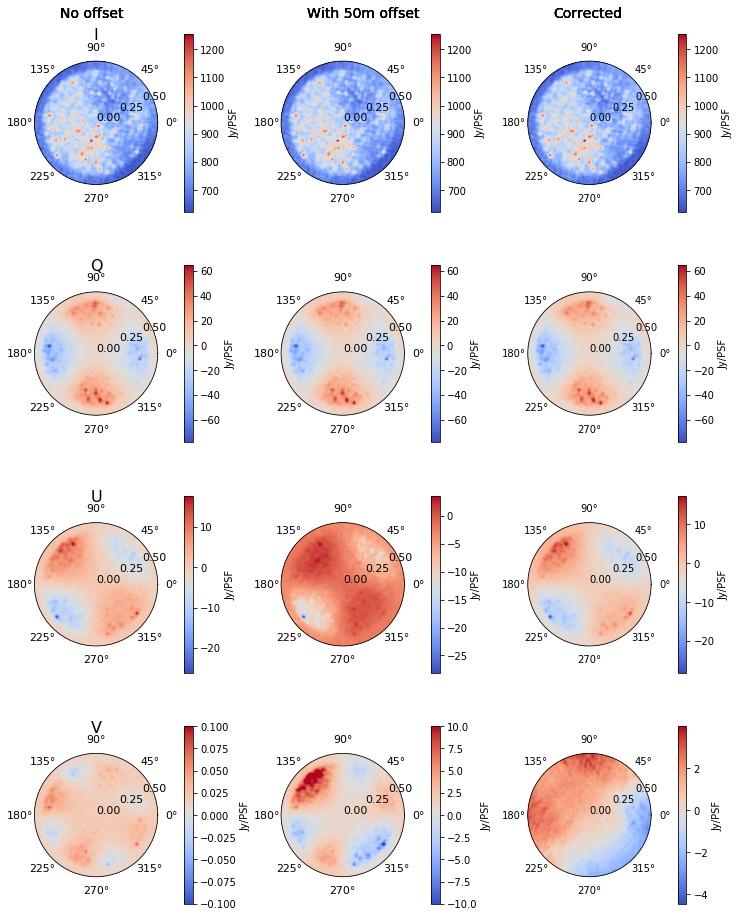

In [89]:

text = ['I', 'Q', 'U', 'V']
plt_no = 4
#ext = ['I','V']
fig2,ax2 = plt.subplots(plt_no,3, subplot_kw=dict(polar=True),figsize=(12,16))
plt.subplots_adjust(wspace=0.4,hspace=0.3)

#fig2.suptitle('Dipole beam on regolith @ '+ str(f)+'MHz',fontsize=14,y=1)

for i in range(plt_no):
    if i ==3:
        p2 = ax2[int(i%plt_no),0].pcolormesh(p,t,np.real(sky_pol[i]),cmap='coolwarm',vmin=-0.1,vmax=0.1)
    else:
        p2 = ax2[int(i%plt_no),0].pcolormesh(p,t,np.real(sky_pol[i]),cmap='coolwarm')#,vmin=vmin, vmax = vmax)#,norm=LogNorm())#,)  
    cbar = plt.colorbar(p2, ax=ax2[int(i%plt_no),0],label='Jy/PSF',pad=0.15)
    ax2[int(i%plt_no),0].set_rticks([0,0.25,0.5])
    ax2[int(i%plt_no),0].tick_params(axis='both', labelsize=11)
    ax2[int(i%plt_no),0].set_ylim([0,35*np.pi/180])
    ax2[int(i%plt_no),0].set_title(text[i], pad=15, fontsize = 16)
    ax2[0,0].text(1.9,1.1,'No offset', fontsize=14)
    ax2[int(i%plt_no),0].set_rlabel_position(25)


###########################################################################################
    if i ==3:
         p2 = ax2[int(i%plt_no),1].pcolormesh(p,t,np.real(sky_pol_off[i]),cmap='coolwarm', vmin=-10,vmax=10)
    else:
        p2 = ax2[int(i%plt_no),1].pcolormesh(p,t,np.real(sky_pol_off[i]),cmap='coolwarm')#,vmin=vmin, vmax = vmax)  
    cbar = plt.colorbar(p2, ax=ax2[int(i%plt_no),1],label='Jy/PSF',pad=0.15)
    #cbar.set_ticks(clist)
    ax2[int(i%plt_no),1].tick_params(axis='both', labelsize=11)
    ax2[int(i%plt_no),1].set_rticks([0,0.25,0.5])
    ax2[int(i%plt_no),1].set_ylim([0,35*np.pi/180])
    ax2[0,1].text(1.9,1.1,'With 50m offset', fontsize=14)
    ax2[int(i%plt_no),1].set_rlabel_position(25)

#########################################################################################
    if i==3:
            p2 = ax2[int(i%plt_no),2].pcolormesh(p,t,np.real(sky_pol_offc[i]),cmap='coolwarm')#,vmin=-0.1,vmax=0.1)
    else:
        p2 = ax2[int(i%plt_no),2].pcolormesh(p,t,np.real(sky_pol_offc[i]),cmap='coolwarm')#,vmin=0, vmax = 0.1)  
    plt.colorbar(p2, ax=ax2[int(i%plt_no),2],label='Jy/PSF',pad=0.15)
    ax2[int(i%plt_no),0].tick_params(axis='both', labelsize=11)
    ax2[int(i%plt_no),2].set_rticks([0,0.25,0.5])
    ax2[int(i%plt_no),2].set_ylim([0,35*np.pi/180])
    ax2[0,2].text(1.9,1.1,'Corrected', fontsize=14)
    ax2[int(i%plt_no),2].set_rlabel_position(25)

#plt.savefig('/data4/nmahesh/edges/Lunar/plot_stokes_image_InV_GLEAM_off_nooff_2mhz_real.png',dpi=800,bbox_inches='tight')



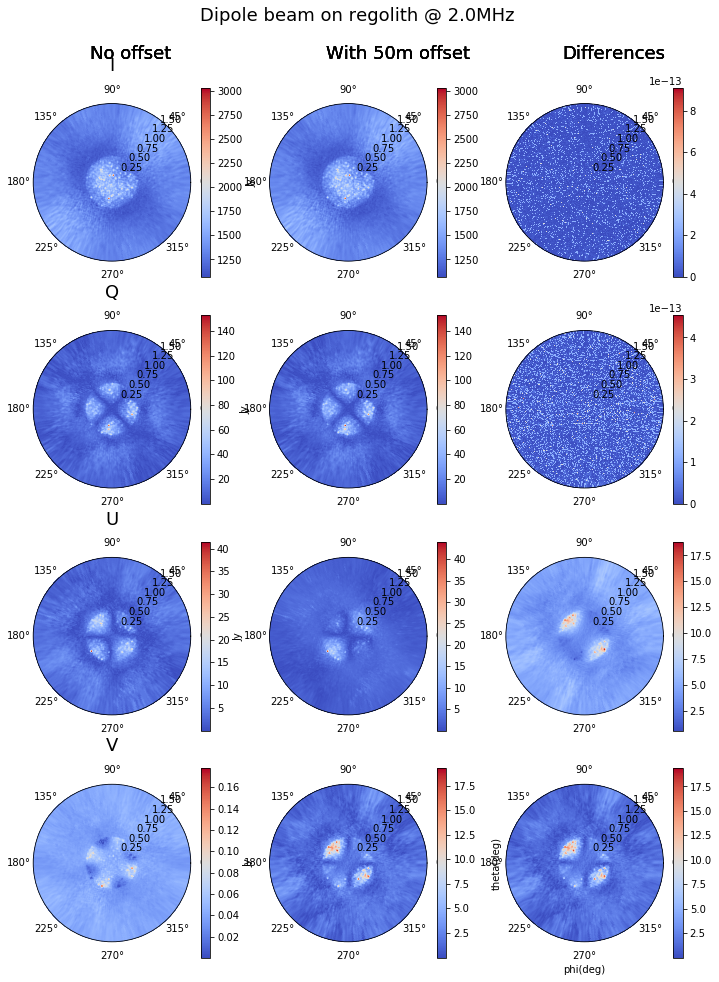

In [68]:
sky_pol = beamtopol(final)
sky_pol_off = beamtopol(final_off)

text = ['I', 'Q', 'U', 'V']
fig2,ax2 = plt.subplots(4,3, subplot_kw=dict(polar=True),figsize=(12,16))

fig2.suptitle('Dipole beam on regolith @ '+ str(f)+'MHz',fontsize=18,y=0.95)

for i in range(4):
    p2 = ax2[int(i%4),0].pcolormesh(p,t,np.abs(sky_pol[i]),cmap='coolwarm')#,norm=LogNorm())#,vmin=0, vmax = 0.0005)  
    plt.colorbar(p2, ax=ax2[int(i%4),0],label='Jy')
    #hb.Label.String = 'Jy'
    plt.ylabel('theta(deg)')
    plt.xlabel('phi(deg)')
    ax2[int(i%4),0].set_title(text[i], pad=25, fontsize = 18)
    ax2[0,0].text(1.75,2.5,'No offset', fontsize=18)
    ax2[int(i%4),0].set_rlabel_position(50)


###########################################################################################

    p2 = ax2[int(i%4),1].pcolormesh(p,t,np.abs(sky_pol_off[i]),cmap='coolwarm')#,vmin=0, vmax = 0.0005)  
    plt.colorbar(p2, ax=ax2[int(i%4),1])
    plt.ylabel('theta(deg)')
    plt.xlabel('phi(deg)')
    ax2[0,1].text(1.75,2.5,'With 50m offset', fontsize=18)
    ax2[int(i%4),1].set_rlabel_position(50)

#########################################################################################
    p2 = ax2[int(i%4),2].pcolormesh(p,t,np.abs(sky_pol_off[i] - sky_pol[i]),cmap='coolwarm')#,vmin=0, vmax = 0.0005)  
    plt.colorbar(p2, ax=ax2[int(i%4),2])
    plt.ylabel('theta(deg)')
    plt.xlabel('phi(deg)')
    ax2[0,2].text(1.75,2.5,'Differences', fontsize=18)
    ax2[int(i%4),2].set_rlabel_position(50)




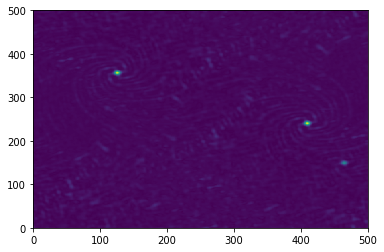

In [29]:
plt.pcolormesh(np.abs(sky_obj.image[0]))

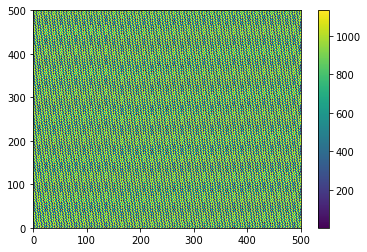

In [31]:
plt.pcolormesh(np.abs(sky_obj.beam_ft[2]));plt.colorbar()

In [45]:
sky_obj.J_b[:,:,0,0]

array([[ 1. +0.j       ,  0. +0.j       ],
       [ 0. +0.j       , -0.5+0.8660254j]])

In [23]:
sky_obj.J_in[:,:,0,0]*sky_obj.J_b[:,:,0,0]

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

In [50]:
1/(-0.5+0.8660254j *  1. +0.j )

(-0.5000000032774201-0.8660254056766581j)

In [77]:
c = (fft.fftshift(fft.fft2(fft.fftshift(sky_obj.J_in[1,1]))))

In [78]:
c[0,0]

(-0.7463695143312196-9.421352586969078e-13j)

In [ ]:
fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
p1 =ax.pcolormesh(p,t,np.abs(sky_obj.image[0,0]),cmap='Spectral_r')#,norm=LogNorm())    #,vmin=0, vmax = 0.0005)  
plt.colorbar(p1, ax=ax)
ax.set_ylim([0,35*np.pi/180])


fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
p1 =ax.pcolormesh(p,t,np.abs(sky_obj.image_off[3]),cmap='Spectral_r')#,norm=LogNorm())    #,vmin=0, vmax = 0.0005)  
plt.colorbar(p1, ax=ax)
ax.set_ylim([0,35*np.pi/180])


fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
p1 =ax.pcolormesh(p,t,np.abs(corrected[1,1]),cmap='Spectral_r')#,norm=LogNorm())    #,vmin=0, vmax = 0.0005)  
plt.colorbar(p1, ax=ax)
ax.set_ylim([0,35*np.pi/180])

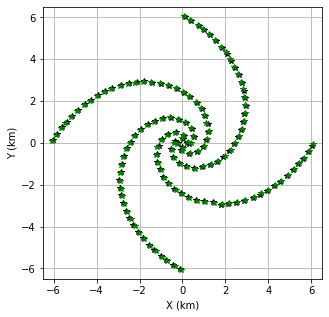

In [41]:
plt.figure(figsize=(5,5))
plt.plot(far_array[:,0],far_array[:,1],'k*')
plt.plot(far_array_off[128:,0],far_array_off[128:,1],'g*')
plt.ylabel('Y (km)')
plt.xlabel('X (km)')
plt.ylim([-6.5,6.5])
plt.xlim([-6.5,6.5])
plt.grid()
plt.savefig('Farside_layout_full.png',dpi=800)

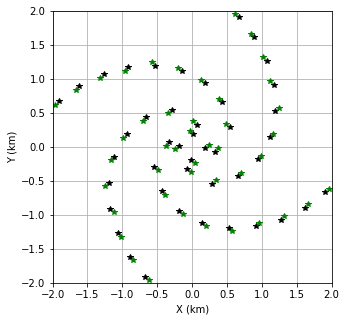

In [42]:
plt.figure(figsize=(5,5))
plt.plot(far_array[:,0],far_array[:,1],'k*')
plt.plot(far_array_off[128:,0],far_array_off[128:,1],'g*')
plt.ylabel('Y (km)')
plt.xlabel('X (km)')
plt.ylim([-2,2])
plt.xlim([-2,2])
plt.grid()
plt.savefig('Farside_layout_zoom_2by2.png',dpi=800)

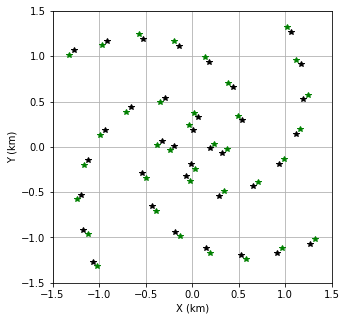

In [161]:
plt.figure(figsize=(5,5))
plt.plot(far_array[:,0],far_array[:,1],'k*')
plt.plot(far_array_off[128:,0],far_array_off[128:,1],'g*')
plt.ylabel('Y (km)')
plt.xlabel('X (km)')
plt.ylim([-1.5,1.5])
plt.xlim([-1.5,1.5])
plt.grid()
plt.savefig('Farside_layout_1p5by1p5.png',dpi=800)

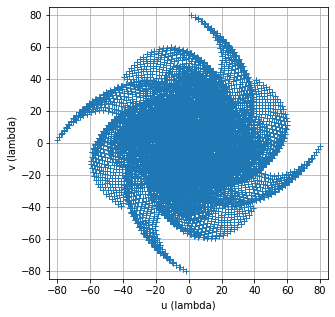

In [149]:
plt.figure(figsize=(5,5))
u,v,w = uvcal(0,0,wav,far_array)
plt.plot(u,v,'+')
plt.grid()
plt.ylabel('v (lambda)')
plt.xlabel('u (lambda)')
plt.ylim([-85,85])
plt.xlim([-85,85])
plt.savefig('/data4/nmahesh/edges/Lunar/uv-coverage_XX-YY_2MHz.png',dpi=800)

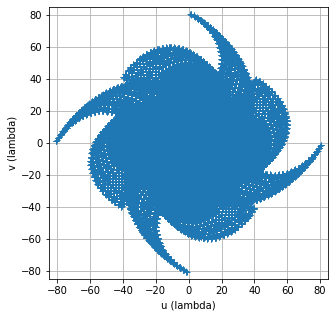

In [150]:
plt.figure(figsize=(5,5))
u,v,w = uvcal(0,0,wav,far_array_off)
plt.plot(u,v,'+')
plt.grid()
plt.ylabel('v (lambda)')
plt.xlabel('u (lambda)')
plt.ylim([-85,85])
plt.xlim([-85,85])
plt.savefig('/data4/nmahesh/edges/Lunar/uv-coverage_XY_2MHz.png',dpi=800)

Text(0.5, 0, 'u (lambda)')

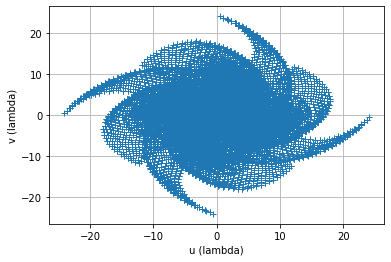

In [146]:
u,v,w = uvcal(0,0,500,far_array)
plt.plot(u,v,'+')
plt.grid()
plt.ylabel('v (lambda)')
plt.xlabel('u (lambda)')